### Libraries

In [28]:
import os
import numpy as np
import pandas as pd
from nitime.timeseries import TimeSeries
from nitime.analysis import SpectralAnalyzer, FilterAnalyzer, NormalizationAnalyzer
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt

In [29]:
def lorentzian_function(x, s0, corner):
    return (s0*corner**2) / (x**2 + corner**2)

In [30]:
def multi_fractal_function(x, beta_low, beta_high, A, B, corner):
    return np.where(x < corner, A * x**beta_low, B * x**beta_high)

In [31]:
# Function to visualize the original time series
def visualize_time_series(time_series, sampling_interval, title="Time Series"):
    # Generate time points based on the sampling interval and length of the series
    time_points = [i * sampling_interval for i in range(len(time_series))]
    
    plt.figure(figsize=(8, 5))
    plt.plot(time_points, time_series, label='Time Series', linewidth=1.5, color='green')
    plt.xlabel('Time (s)')
    plt.ylabel('Signal Intensity')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

In [32]:
# Function to visualize the Power Spectral Density
def visualize_psd(xdata, ydata, f1, f2, title="Power Spectral Density"):
    plt.figure(figsize=(8, 5))
    plt.plot(xdata, ydata, label='PSD', linewidth=1.5, color='blue')
    
    # Add dashed vertical lines at f1 and f2
    plt.axvline(x=f1, color='red', linestyle='--', label=f'Boundary f1: {f1}')
    plt.axvline(x=f2, color='green', linestyle='--', label=f'Boundary f2: {f2}')
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

In [33]:
def visualize_log_psd(xdata, ydata, f1, f2, title="Log-Log Power Spectral Density", xlabel="Log(Frequency)", ylabel="Log(Power)"):
    """
    Visualize the Power Spectral Density (PSD) with log-log transformation.

    Parameters:
    - xdata (numpy array): Frequency values.
    - ydata (numpy array): Power values.
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    """
    # Apply log transformation
    log_xdata = np.log10(xdata)
    log_ydata = np.log10(ydata)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(log_xdata, log_ydata, label="Log-Log PSD", linewidth=2, color='blue')

    # Add dashed vertical lines at f1 and f2
    # plt.axvline(x=np.log10(f1), color='red', linestyle='--', label=f'Boundary log(f1): {np.log10(f1)}')
    # plt.axvline(x=np.log10(f2), color='green', linestyle='--', label=f'Boundary log(f2): {np.log10(f2)}')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()


In [34]:
# Function for Gaussian smoothing with FWHM input
def gaussian_smoothing_with_fwhm(data, fwhm):
    """
    Apply Gaussian kernel smoothing to a time series with FWHM.

    Parameters:
    - data (numpy array): Input time-series data.
    - fwhm (float): Full-width at half-maximum (FWHM) for the Gaussian kernel.

    Returns:
    - smoothed_data (numpy array): Smoothed time-series data.
    """
    sigma = fwhm / 2.3548  # Convert FWHM to sigma
    smoothed_data = gaussian_filter1d(data, sigma=sigma)
    return smoothed_data

In [35]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a band-pass filter to the fMRI time-series data.

    Parameters:
    - data (numpy array): Input time-series data (1D).
    - lowcut (float): Low cutoff frequency in Hz.
    - highcut (float): High cutoff frequency in Hz.
    - fs (float): Sampling frequency (1/TR in Hz).
    - order (int): Order of the Butterworth filter.

    Returns:
    - filtered_data (numpy array): Band-pass filtered data.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')  # Band-pass filter coefficients
    filtered_data = filtfilt(b, a, data)  # Apply the filter
    return filtered_data


In [36]:
def lowpass_filter(data, highcut, fs, order=4):
    """
    Apply a low-pass filter to the fMRI time-series data.

    Parameters:
    - data (numpy array): Input time-series data (1D).
    - highcut (float): High cutoff frequency in Hz.
    - fs (float): Sampling frequency (1/TR in Hz).
    - order (int): Order of the Butterworth filter.

    Returns:
    - filtered_data (numpy array): Low-pass filtered data.
    """
    if highcut <= 0 or highcut >= 0.5 * fs:
        raise ValueError("High cutoff frequency must lie within the range (0, Nyquist frequency).")

    nyquist = 0.5 * fs  # Nyquist frequency
    print(f"Nyquist frequency equals: {nyquist}")

    high = highcut / nyquist
    b, a = butter(order, high, btype='low')  # Low-pass filter coefficients
    filtered_data = filtfilt(b, a, data)  # Apply the filter
    return filtered_data


### ENIGMA-OCD

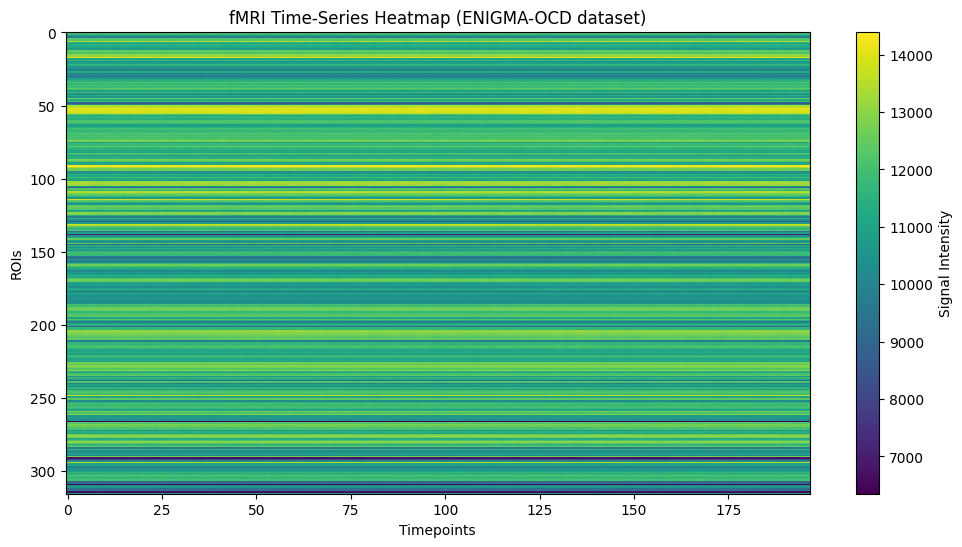

In [52]:
# Example fMRI time-series data (timepoints x ROIs)
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Amsterdam-VUmc_sub-916002/Amsterdam-VUmc_sub-916002.npy")
# time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Brazil_sub-P00196820141124/Brazil_sub-P00196820141124.npy")


# Plot the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(time_series_data.T, aspect="auto", cmap="viridis", interpolation="nearest")
plt.colorbar(label="Signal Intensity")
plt.xlabel("Timepoints")
plt.ylabel("ROIs")
plt.title("fMRI Time-Series Heatmap (ENIGMA-OCD dataset)")
plt.show()


In [53]:
y = time_series_data.T # [180, seq_len]
ts_length = y.shape[1]
TR = 1.8

'''
get knee frequency
'''

sample_whole = np.zeros(ts_length,)
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec   
print(f"sample_whole: {sample_whole}") 

T = TimeSeries(sample_whole, sampling_interval=TR)
print(f"T: {T}")
S_original = SpectralAnalyzer(T)
print(f"S_original: {S_original}")

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

# initial parameter
p0 = [0, 0.006]

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))
print(f"knee value: {knee}")

if knee <= 0:
    knee = 1

# initial parameter
p1 = [2, 1, 23, 25, 0.16]
# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

print(f"frequency_range max: {xdata.shape[0]}")
print(f"knee value: {knee}")
print(f"f1: {f1}")
print(f"f2: {f2}")

sample_whole: [11426.79338333 11432.28169901 11435.05616394 11421.97078512
 11444.21055045 11428.06133549 11427.43895797 11420.90611909
 11414.83591662 11424.91972598 11431.92397609 11441.62219661
 11421.73507863 11441.88395704 11439.15685044 11428.27037655
 11435.68989431 11437.41059793 11435.69546769 11441.61391811
 11443.06270678 11431.37661904 11422.78782538 11431.02984552
 11436.0919446  11436.17079544 11429.98832399 11432.06121566
 11424.22890357 11432.23800396 11431.55100641 11429.1253675
 11434.34421133 11431.51899491 11439.23970024 11418.66982383
 11437.41207429 11429.78591149 11434.83918437 11434.02461611
 11434.93205513 11427.97444417 11430.35998971 11423.01940591
 11418.15367472 11429.09754948 11439.57836433 11433.33028253
 11440.49673657 11436.95695857 11451.95877067 11437.30962529
 11425.62231857 11451.05582865 11443.11721597 11445.82919435
 11439.13268128 11440.62860311 11434.87096567 11448.21612708
 11433.34445347 11447.03931543 11423.76464095 11426.62012847
 11434.1241

/tmp/ipykernel_1121689/1867528834.py:2: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_1121689/1867528834.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_1121689/947982326.py:44: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


In [54]:
# Assuming T is your TimeSeries object
print("Data Shape:", T.data.shape)  # Access the data array
print("Sampling Interval:", T.sampling_interval)
print("Time Points:", T.time)

# Perform basic operations on the data
print("Mean:", T.data.mean())
print("Standard Deviation:", T.data.std())
print("Min:", T.data.min())
print("Max:", T.data.max())


Data Shape: (197,)
Sampling Interval: 1.8 s
Time Points: [              0   1800000000000   3600000000000   5400000000000
   7200000000000   9000000000000  10800000000000  12600000000000
  14400000000000  16200000000000  18000000000000  19800000000000
  21600000000000  23400000000000  25200000000000  27000000000000
  28800000000000  30600000000000  32400000000000  34200000000000
  36000000000000  37800000000000  39600000000000  41400000000000
  43200000000000  45000000000000  46800000000000  48600000000000
  50400000000000  52200000000000  54000000000000  55800000000000
  57600000000000  59400000000000  61200000000000  63000000000000
  64800000000000  66600000000000  68400000000000  70200000000000
  72000000000000  73800000000000  75600000000000  77400000000000
  79200000000000  81000000000000  82800000000000  84600000000000
  86400000000000  88200000000000  90000000000000  91800000000000
  93600000000000  95400000000000  97200000000000  99000000000000
 100800000000000 102600000000000 

##### Original time series

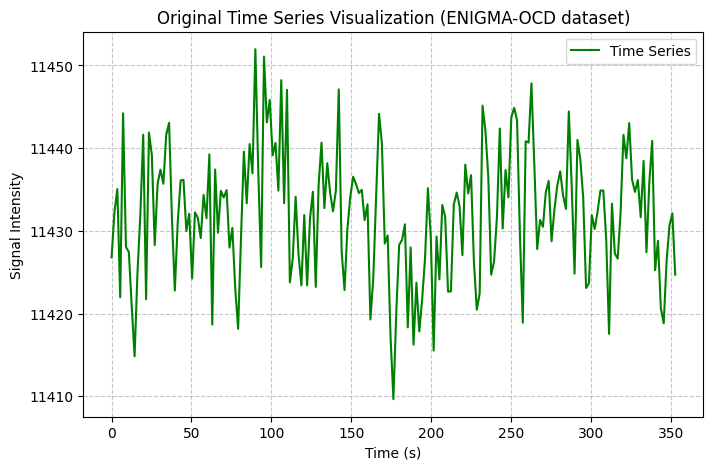

In [55]:
# Assuming `sample_whole` is the original time-series data and `TR` is the sampling interval
visualize_time_series(sample_whole, TR, title="Original Time Series Visualization (ENIGMA-OCD dataset)")

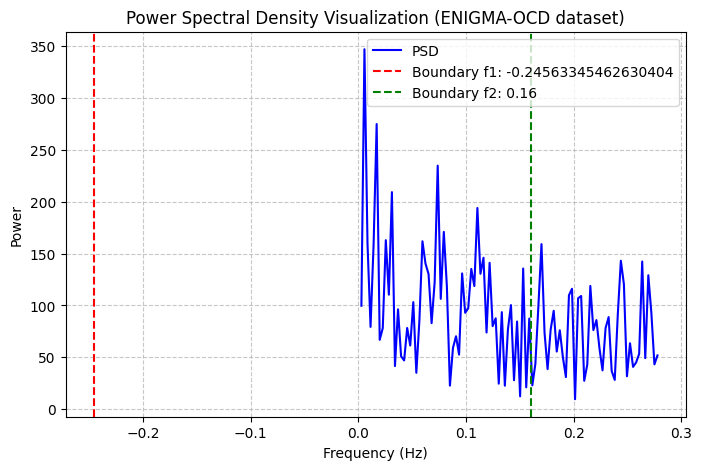

In [56]:
# visualize PSD
visualize_psd(xdata, ydata, f1, f2, title="Power Spectral Density Visualization (ENIGMA-OCD dataset)")


##### Gaussian kernel smoothing

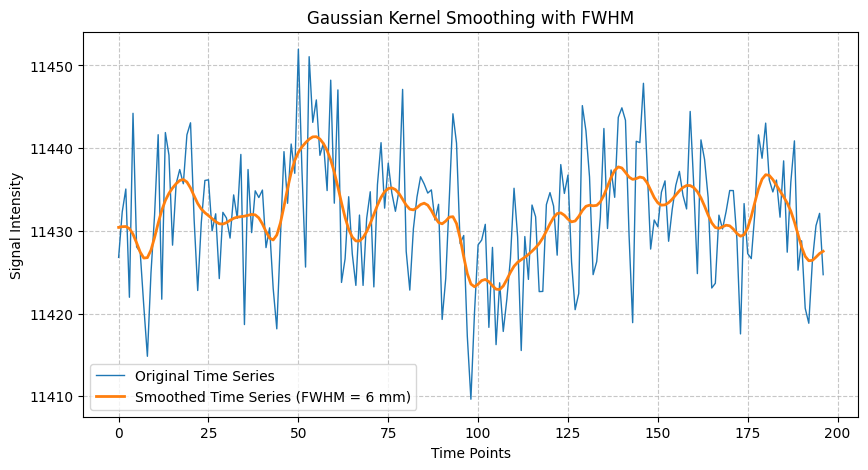

In [57]:
# Parameters
fwhm = 4  # Full-width at half-maximum in mm (adjust as needed)

# Apply Gaussian smoothing
smoothed_sample_whole = gaussian_smoothing_with_fwhm(sample_whole, fwhm)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(sample_whole, label='Original Time Series', linewidth=1)
plt.plot(smoothed_sample_whole, label=f'Smoothed Time Series (FWHM = {fwhm} mm)', linewidth=2)
plt.xlabel('Time Points')
plt.ylabel('Signal Intensity')
plt.title('Gaussian Kernel Smoothing with FWHM')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

/tmp/ipykernel_1121689/1867528834.py:2: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_1121689/1867528834.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_1121689/2822673536.py:25: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


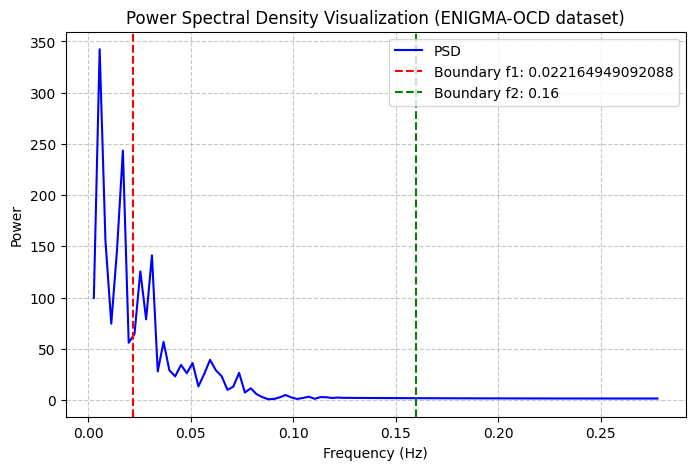

In [58]:
# visualize PSD
T = TimeSeries(smoothed_sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

# initial parameter
p0 = [0, 0.006]

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

# initial parameter
p1 = [2, 1, 23, 25, 0.16]
# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

visualize_psd(xdata, ydata, f1, f2, title="Power Spectral Density Visualization (ENIGMA-OCD dataset)")


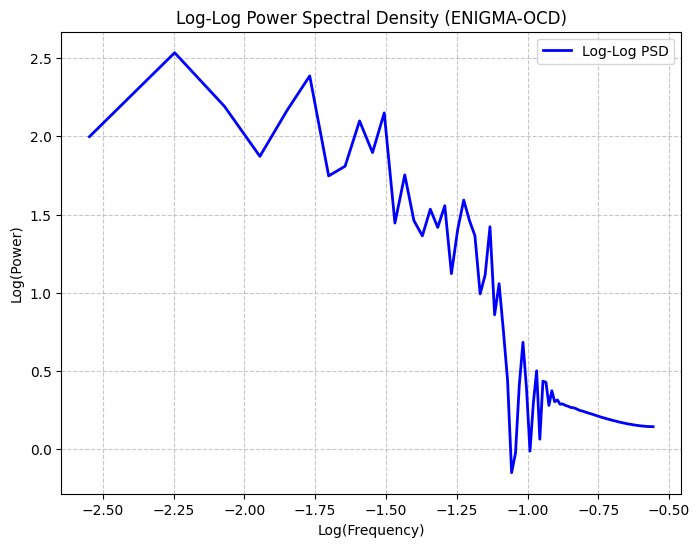

In [59]:
# Call the function to visualize log-log PSD
visualize_log_psd(xdata, ydata, f1, f2, title="Log-Log Power Spectral Density (ENIGMA-OCD)")

In [60]:
# initial parameter
p0 = [0, 0.006]

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(smoothed_sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

# initial parameter
p1 = [2, 1, 23, 25, 0.16]
# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(smoothed_sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

print(f"frequency_range max: {xdata.shape[0]}")
print(f"knee value: {knee}")
print(f"f1: {f1}")
print(f"f2: {f2}")

frequency_range max: 98
knee value: 8
f1: 0.022164949092088
f2: 0.16


/tmp/ipykernel_1121689/1867528834.py:2: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_1121689/1867528834.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_1121689/4163573923.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


##### Bandpass filtering

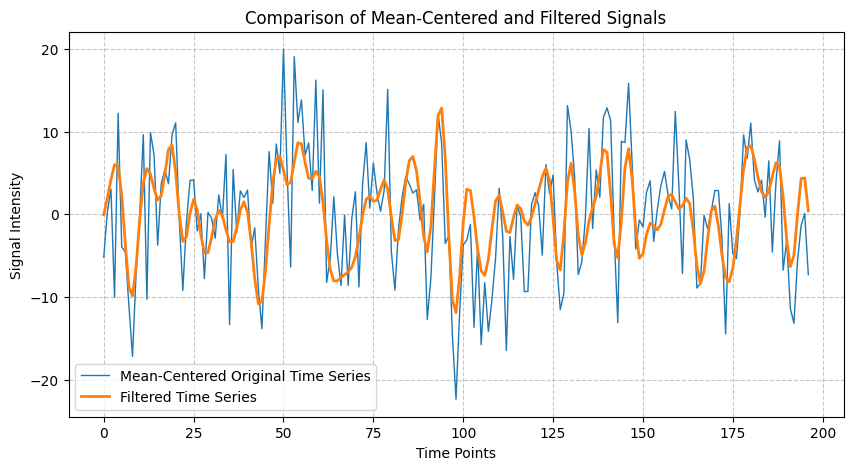

In [61]:
TR = 1.8 # Repetition time in seconds
fs = 1 / TR  # Sampling frequency in Hz
lowcut = 0.01  # Low cutoff frequency in Hz
highcut = 0.1  # High cutoff frequency in Hz

# Apply the band-pass filter to the time series
filtered_sample_whole = bandpass_filter(sample_whole, lowcut, highcut, fs)

mean_centered_sample_whole = sample_whole - np.mean(sample_whole)
plt.figure(figsize=(10, 5))
plt.plot(mean_centered_sample_whole, label='Mean-Centered Original Time Series', linewidth=1)
plt.plot(filtered_sample_whole, label='Filtered Time Series', linewidth=2)
plt.xlabel('Time Points')
plt.ylabel('Signal Intensity')
plt.title('Comparison of Mean-Centered and Filtered Signals')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


/tmp/ipykernel_1121689/1867528834.py:2: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_1121689/1867528834.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_1121689/410169028.py:25: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


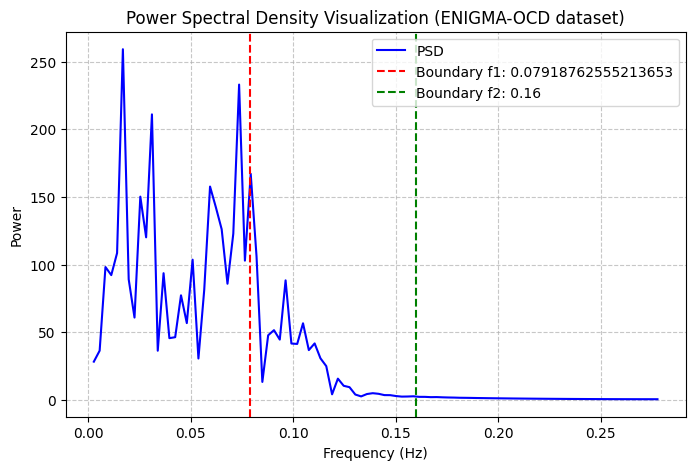

In [62]:
# visualize PSD
T = TimeSeries(filtered_sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

# initial parameter
p0 = [0, 0.006]

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

# initial parameter
p1 = [2, 1, 23, 25, 0.16]
# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

visualize_psd(xdata, ydata, f1, f2, title="Power Spectral Density Visualization (ENIGMA-OCD dataset)")


### Low-pass filtering

Nyquist frequency equals: 0.2777777777777778


/tmp/ipykernel_1121689/3984650053.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


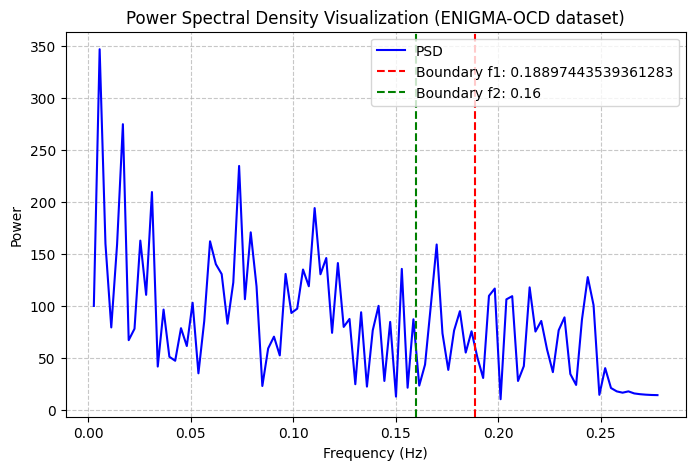

In [63]:
TR = 1.8 # Repetition time in seconds
fs = 1 / TR  # Sampling frequency in Hz
highcut = 0.25  # High cutoff frequency in Hz

# Apply the band-pass filter to the time series
filtered_sample_whole = lowpass_filter(sample_whole, highcut, fs)

# visualize PSD
T = TimeSeries(filtered_sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

# initial parameter
p0 = [0, 0.006]

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

# initial parameter
p1 = [2, 1, 23, 25, 0.16]
# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

visualize_psd(xdata, ydata, f1, f2, title="Power Spectral Density Visualization (ENIGMA-OCD dataset)")



### ABCD

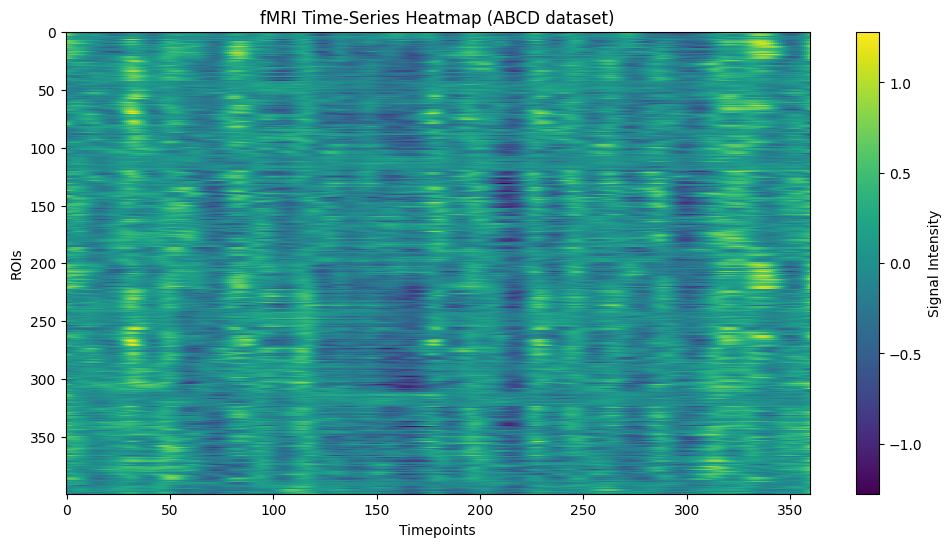

In [102]:
# Example fMRI time-series data (timepoints x ROIs)
time_series_data = np.load("/global/homes/p/pakmasha/ENIGMA-OCD results/Examples from other datasets/schaefer_sub-NDARINV0A4P0LWM.npy")

# Plot the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(time_series_data.T, aspect="auto", cmap="viridis", interpolation="nearest")
plt.colorbar(label="Signal Intensity")
plt.xlabel("Timepoints")
plt.ylabel("ROIs")
plt.title("fMRI Time-Series Heatmap (ABCD dataset)")
plt.show()


In [103]:
y = time_series_data.T # [180, seq_len]
ts_length = y.shape[1]

TR = 0.8

'''
get knee frequency
'''

sample_whole = np.zeros(ts_length,)
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec    

T = TimeSeries(sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)
print(f"S_original: {S_original}")

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

# initial parameter
p0 = [0, 0.006]

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

# initial parameter
p1 = [2, 1, 23, 25, 0.16]

# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

print(f"frequency_range max: {xdata.shape[0]}")
print(f"knee value: {knee}")
print(f"f1: {f1}")
print(f"f2: {f2}")

S_original: SpectralAnalyzer(method={'this_method': 'welch', 'Fs': 1.25 Hz}, BW=None, adaptive=False, low_bias=False)
frequency_range max: 180
knee value: 13
f1: 0.045045602454074074
f2: 0.16


/tmp/ipykernel_1798427/2117158043.py:43: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


In [104]:
# Assuming T is your TimeSeries object
print("Data Shape:", T.data.shape)  # Access the data array
print("Sampling Interval:", T.sampling_interval)
print("Time Points:", T.time)

# Perform basic operations on the data
print("Mean:", T.data.mean())
print("Standard Deviation:", T.data.std())
print("Min:", T.data.min())
print("Max:", T.data.max())


Data Shape: (360,)
Sampling Interval: 0.8 s
Time Points: [              0    800000000000   1600000000000   2400000000000
   3200000000000   4000000000000   4800000000000   5600000000000
   6400000000000   7200000000000   8000000000000   8800000000000
   9600000000000  10400000000000  11200000000000  12000000000000
  12800000000000  13600000000000  14400000000000  15200000000000
  16000000000000  16800000000000  17600000000000  18400000000000
  19200000000000  20000000000000  20800000000000  21600000000000
  22400000000000  23200000000000  24000000000000  24800000000000
  25600000000000  26400000000000  27200000000000  28000000000000
  28800000000000  29600000000000  30400000000000  31200000000000
  32000000000000  32800000000000  33600000000000  34400000000000
  35200000000000  36000000000000  36800000000000  37600000000000
  38400000000000  39200000000000  40000000000000  40800000000000
  41600000000000  42400000000000  43200000000000  44000000000000
  44800000000000  45600000000000 

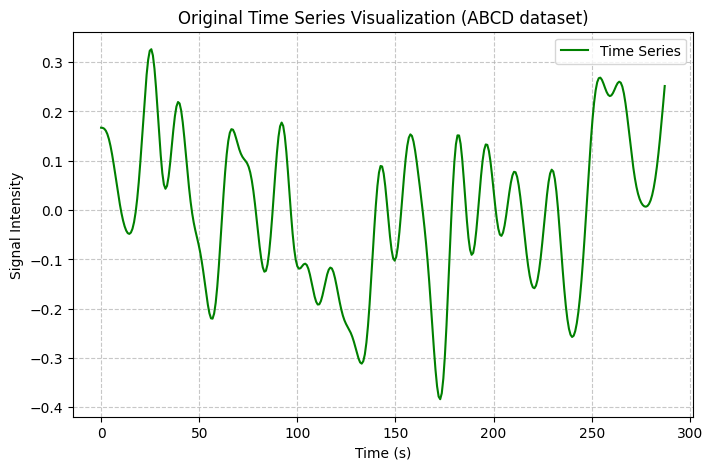

In [105]:
# Assuming `sample_whole` is the original time-series data and `TR` is the sampling interval
visualize_time_series(sample_whole, TR, title="Original Time Series Visualization (ABCD dataset)")

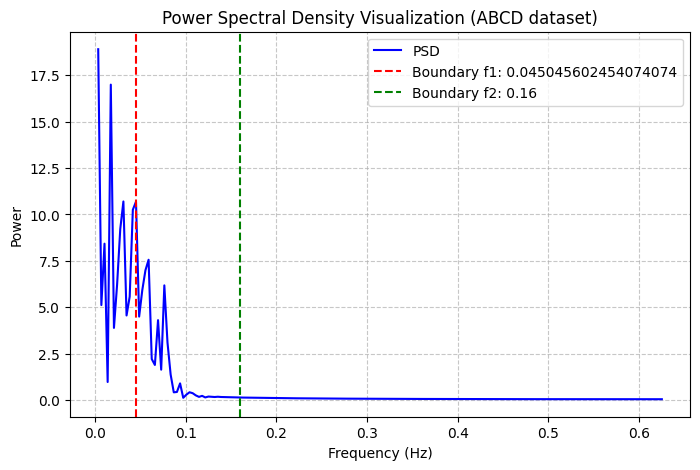

In [106]:
# visualize PSD
visualize_psd(xdata, ydata, f1, f2, title="Power Spectral Density Visualization (ABCD dataset)")


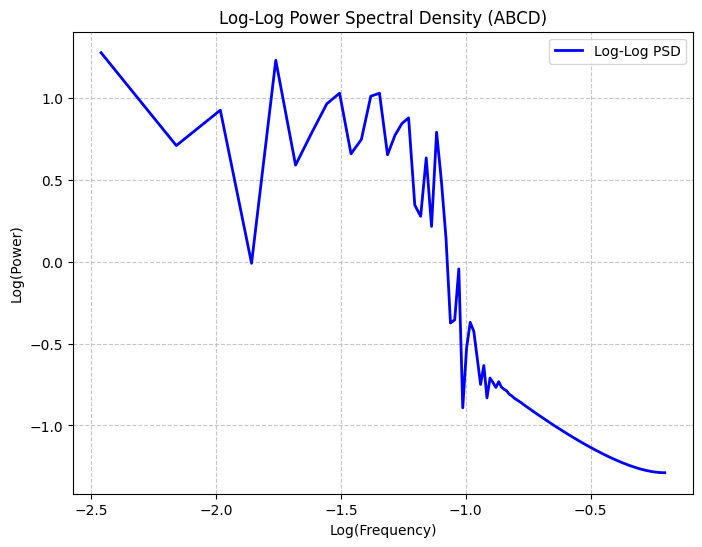

In [107]:
# Call the function to visualize log-log PSD
visualize_log_psd(xdata, ydata, f1, f2, title="Log-Log Power Spectral Density (ABCD)")

##### Estimate initial parameters for the multifractal model

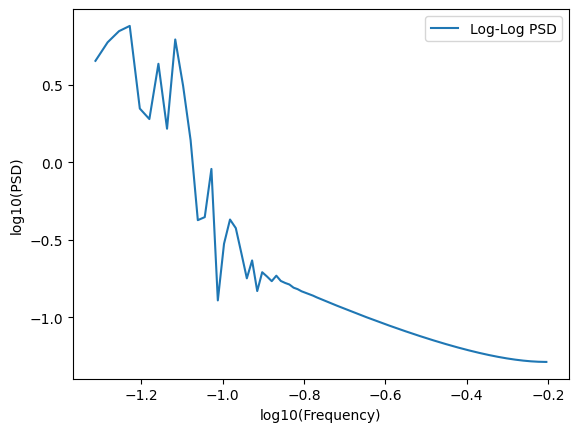

Estimated alpha: 4.309253374662768, Estimated A: 2.2416421840782995e-05


In [44]:
# Assuming freq and psd are your frequency and PSD arrays
log_freq = np.log10(xdata[knee:])
log_psd = np.log10(ydata[knee:])

plt.plot(log_freq, log_psd, label="Log-Log PSD")
plt.xlabel("log10(Frequency)")
plt.ylabel("log10(PSD)")
plt.legend()
plt.show()

from scipy.stats import linregress

# Focus on low-frequency region (e.g., freq < 0.1 Hz)
low_freq_mask = xdata[knee:] < 0.1
slope, intercept, _, _, _ = linregress(log_freq[low_freq_mask], log_psd[low_freq_mask])

alpha = -slope  # Scaling exponent
A = 10**intercept  # Amplitude
print(f"Estimated alpha: {alpha}, Estimated A: {A}") # Parameters 1 and 2


In [50]:
# Parameter 3: Manually note the frequency where the slope changes in the PSD plot.
f_c = -0.85
print(f"Estimated f_c: {f_c}")

Estimated f_c: -0.85


In [48]:
high_freq_mask = xdata[knee:] > f_c
log_high_psd = np.log(ydata[knee:][high_freq_mask])  # Linearize exponential decay

slope, _, _, _, _ = linregress(xdata[knee:][high_freq_mask], log_high_psd)
C = -slope
print(f"Estimated C: {C}") # Parameter 4

Estimated C: 4.7622582354270735


In [49]:
noise_floor = np.mean(ydata[knee:][xdata[knee:] > (0.8 * max(xdata[knee:]))])  # High-frequency average
print(f"Estimated D: {noise_floor}") # Parameter 5

Estimated D: 0.052334964299313544


##### Try to solve the multifractal fitting issue

In [63]:
y = time_series_data.T # [180, seq_len]
ts_length = y.shape[1]

TR = 0.8

'''
get knee frequency
'''

sample_whole = np.zeros(ts_length,)
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec    

T = TimeSeries(sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)
print(f"S_original: {S_original}")

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

# # Gaussian smoothing
# from scipy.ndimage import gaussian_filter1d
# ydata = gaussian_filter1d(ydata, sigma=0.1)  # Adjust sigma as needed

# initial parameter
p0 = [0, 0.006]

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

# initial parameter
# p1 = [2, 1, 23, 25, 0.16]
p1 = [4.3,2.2,-0.85,4.8,0.05] # initial parameters approximately estimated from the graph
# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

print(f"frequency_range max: {xdata.shape[0]}")
print(f"knee value: {knee}")
print(f"f1: {f1}")
print(f"f2: {f2}")

S_original: SpectralAnalyzer(method={'this_method': 'welch', 'Fs': 1.25 Hz}, BW=None, adaptive=False, low_bias=False)
frequency_range max: 180
knee value: 13
f1: 0.045045602454074074
f2: 0.05


/tmp/ipykernel_1798427/1867528834.py:2: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_1798427/631662454.py:47: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


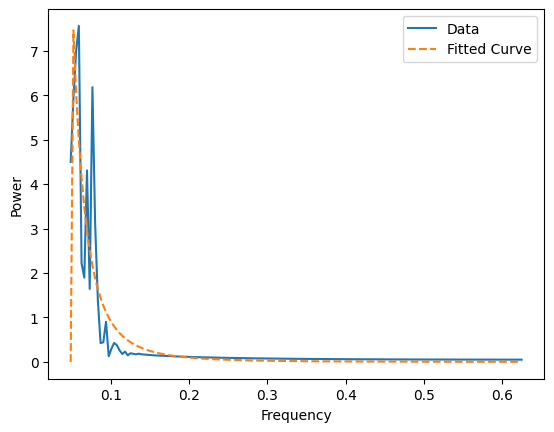

In [64]:
import matplotlib.pyplot as plt

fitted_curve = multi_fractal_function(xdata[knee:], *popt_mo)

plt.plot(xdata[knee:], ydata[knee:], label='Data')
plt.plot(xdata[knee:], fitted_curve, label='Fitted Curve', linestyle='--')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend()
plt.show()


### ABIDE

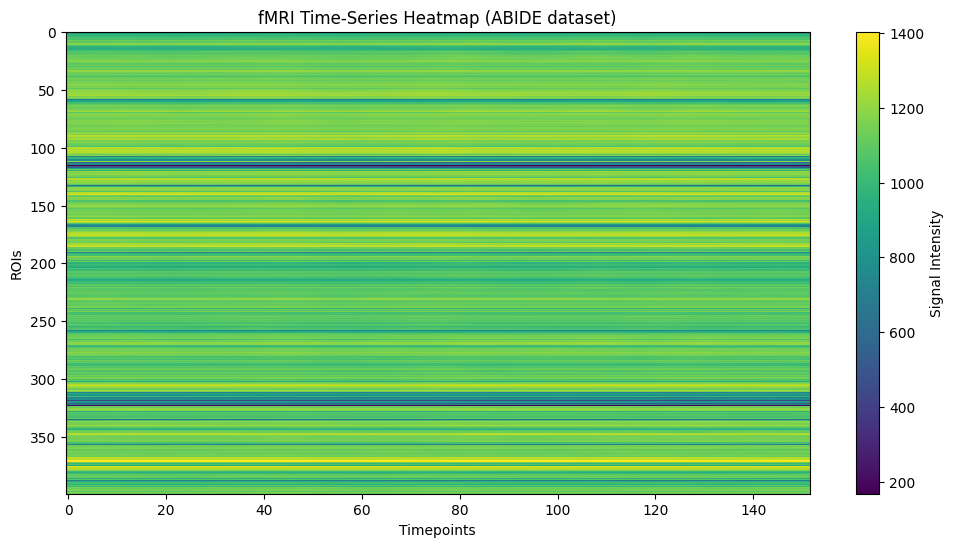

In [108]:
# Example fMRI time-series data (timepoints x ROIs)
time_series_data = np.load("/global/homes/p/pakmasha/ENIGMA-OCD results/Examples from other datasets/schaefer_400Parcels_17Networks_28743.npy")

# Plot the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(time_series_data.T, aspect="auto", cmap="viridis", interpolation="nearest")
plt.colorbar(label="Signal Intensity")
plt.xlabel("Timepoints")
plt.ylabel("ROIs")
plt.title("fMRI Time-Series Heatmap (ABIDE dataset)")
plt.show()


In [109]:
y = time_series_data.T # [180, seq_len]
ts_length = y.shape[1]

TR = 2

'''
get knee frequency
'''

sample_whole = np.zeros(ts_length,)
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec    

T = TimeSeries(sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)
print(f"S_original: {S_original}")

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

# initial parameter
p0 = [0, 0.006]

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

# initial parameter
p1 = [2, 1, 23, 25, 0.16]
# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

print(f"frequency_range max: {xdata.shape[0]}")
print(f"knee value: {knee}")
print(f"f1: {f1}")
print(f"f2: {f2}")

S_original: SpectralAnalyzer(method={'this_method': 'welch', 'Fs': 0.5 Hz}, BW=None, adaptive=False, low_bias=False)
frequency_range max: 76
knee value: 7
f1: 0.024226074841245913
f2: 0.16


/tmp/ipykernel_1798427/2244131933.py:42: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


In [110]:
# Assuming T is your TimeSeries object
print("Data Shape:", T.data.shape)  # Access the data array
print("Sampling Interval:", T.sampling_interval)
print("Time Points:", T.time)

# Perform basic operations on the data
print("Mean:", T.data.mean())
print("Standard Deviation:", T.data.std())
print("Min:", T.data.min())
print("Max:", T.data.max())


Data Shape: (152,)
Sampling Interval: 2.0 s
Time Points: [              0   2000000000000   4000000000000   6000000000000
   8000000000000  10000000000000  12000000000000  14000000000000
  16000000000000  18000000000000  20000000000000  22000000000000
  24000000000000  26000000000000  28000000000000  30000000000000
  32000000000000  34000000000000  36000000000000  38000000000000
  40000000000000  42000000000000  44000000000000  46000000000000
  48000000000000  50000000000000  52000000000000  54000000000000
  56000000000000  58000000000000  60000000000000  62000000000000
  64000000000000  66000000000000  68000000000000  70000000000000
  72000000000000  74000000000000  76000000000000  78000000000000
  80000000000000  82000000000000  84000000000000  86000000000000
  88000000000000  90000000000000  92000000000000  94000000000000
  96000000000000  98000000000000 100000000000000 102000000000000
 104000000000000 106000000000000 108000000000000 110000000000000
 112000000000000 114000000000000 

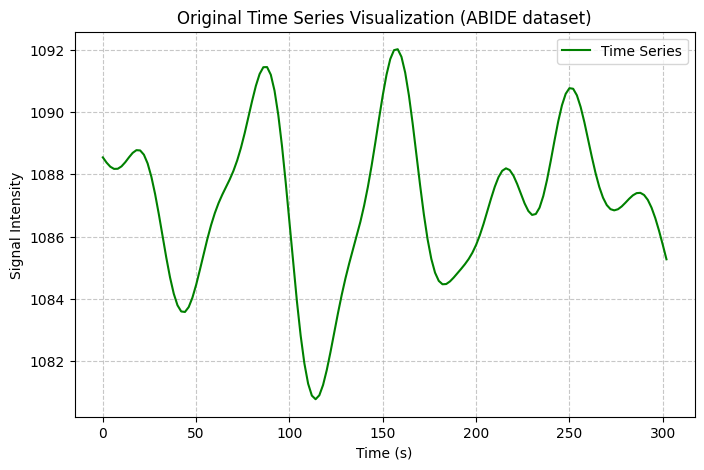

In [111]:
# Assuming `sample_whole` is the original time-series data and `TR` is the sampling interval
visualize_time_series(sample_whole, TR, title="Original Time Series Visualization (ABIDE dataset)")

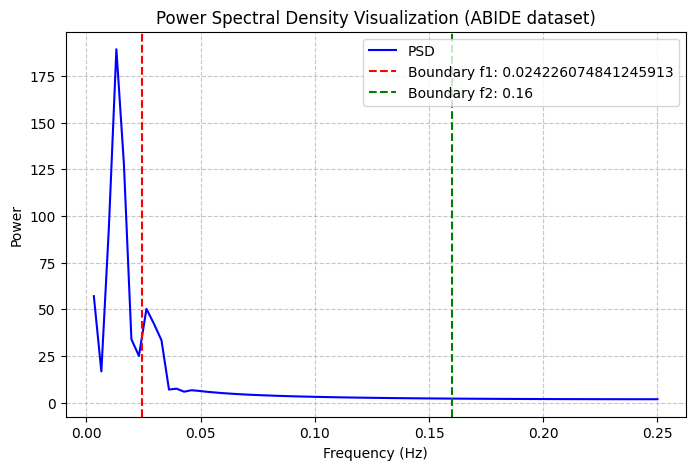

In [112]:
# visualize PSD
visualize_psd(xdata, ydata, f1, f2, title="Power Spectral Density Visualization (ABIDE dataset)")


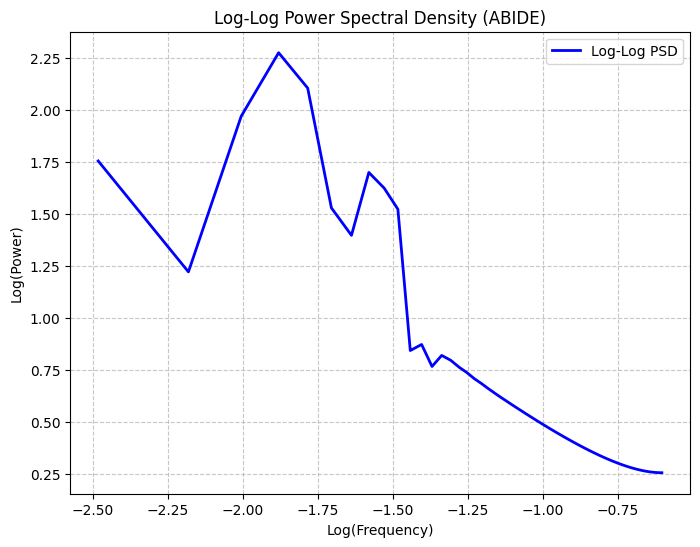

In [113]:
# Call the function to visualize log-log PSD
visualize_log_psd(xdata, ydata, f1, f2, title="Log-Log Power Spectral Density (ABIDE)")

### UKB

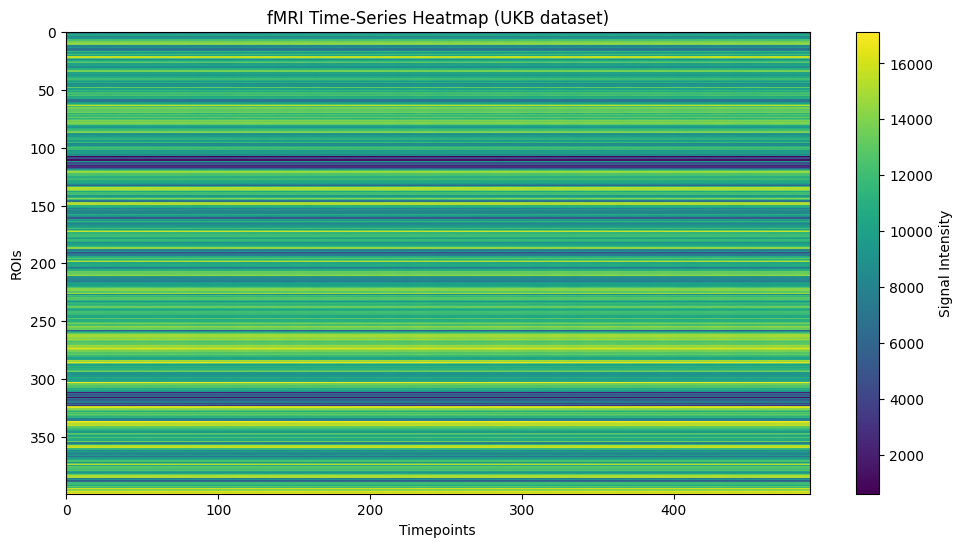

In [114]:
# Example fMRI time-series data (timepoints x ROIs)
time_series_data = np.load("/global/homes/p/pakmasha/ENIGMA-OCD results/Examples from other datasets/schaefer_400Parcels_17Networks_4357334.npy")

# Plot the heatmap
plt.figure(figsize=(12, 6))
plt.imshow(time_series_data.T, aspect="auto", cmap="viridis", interpolation="nearest")
plt.colorbar(label="Signal Intensity")
plt.xlabel("Timepoints")
plt.ylabel("ROIs")
plt.title("fMRI Time-Series Heatmap (UKB dataset)")
plt.show()


In [115]:
y = time_series_data.T # [180, seq_len]
ts_length = y.shape[1]

TR = 0.735

'''
get knee frequency
'''

sample_whole = np.zeros(ts_length,)
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec    

T = TimeSeries(sample_whole, sampling_interval=TR)
# print(f"T: {T}")
S_original = SpectralAnalyzer(T)
print(f"S_original: {S_original}")

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

# initial parameter
p0 = [0, 0.006]

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

# initial parameter
p1 = [2, 1, 23, 25, 0.16]
# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

print(f"frequency_range max: {xdata.shape[0]}")
print(f"knee value: {knee}")
print(f"f1: {f1}")
print(f"f2: {f2}")

S_original: SpectralAnalyzer(method={'this_method': 'welch', 'Fs': 1.3605442176870748 Hz}, BW=None, adaptive=False, low_bias=False)
frequency_range max: 245
knee value: 22
f1: 0.06244037419120084
f2: 0.16


/tmp/ipykernel_1798427/1867528834.py:2: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_1798427/1867528834.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_1798427/3575684946.py:43: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


In [116]:
# Assuming T is your TimeSeries object
print("Data Shape:", T.data.shape)  # Access the data array
print("Sampling Interval:", T.sampling_interval)
print("Time Points:", T.time)

# Perform basic operations on the data
print("Mean:", T.data.mean())
print("Standard Deviation:", T.data.std())
print("Min:", T.data.min())
print("Max:", T.data.max())



Data Shape: (490,)
Sampling Interval: 0.735 s
Time Points: [              0    735000000000   1470000000000   2205000000000
   2940000000000   3675000000000   4410000000000   5145000000000
   5880000000000   6615000000000   7350000000000   8085000000000
   8820000000000   9555000000000  10290000000000  11025000000000
  11760000000000  12495000000000  13230000000000  13965000000000
  14700000000000  15435000000000  16170000000000  16905000000000
  17640000000000  18375000000000  19110000000000  19845000000000
  20580000000000  21315000000000  22050000000000  22785000000000
  23520000000000  24255000000000  24990000000000  25725000000000
  26460000000000  27195000000000  27930000000000  28665000000000
  29400000000000  30135000000000  30870000000000  31605000000000
  32340000000000  33075000000000  33810000000000  34545000000000
  35280000000000  36015000000000  36750000000000  37485000000000
  38220000000000  38955000000000  39690000000000  40425000000000
  41160000000000  4189500000000

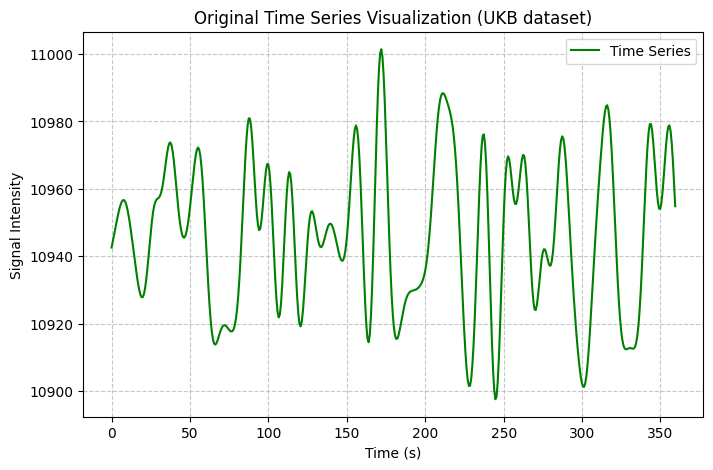

In [117]:
# Assuming `sample_whole` is the original time-series data and `TR` is the sampling interval
visualize_time_series(sample_whole, TR, title="Original Time Series Visualization (UKB dataset)")

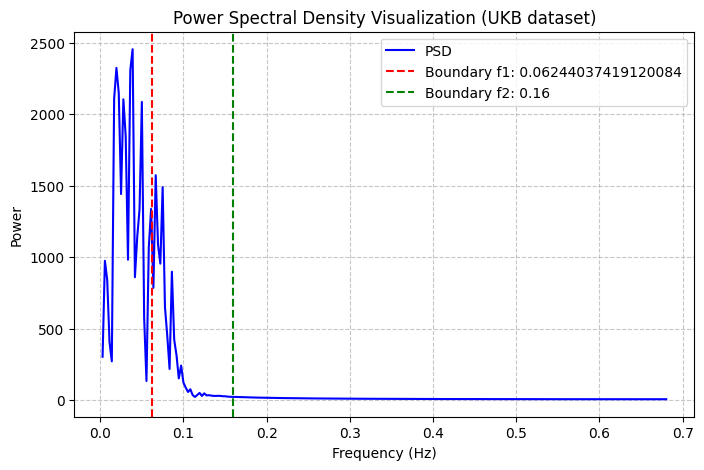

In [118]:
# visualize PSD
visualize_psd(xdata, ydata, f1, f2, title="Power Spectral Density Visualization (UKB dataset)")


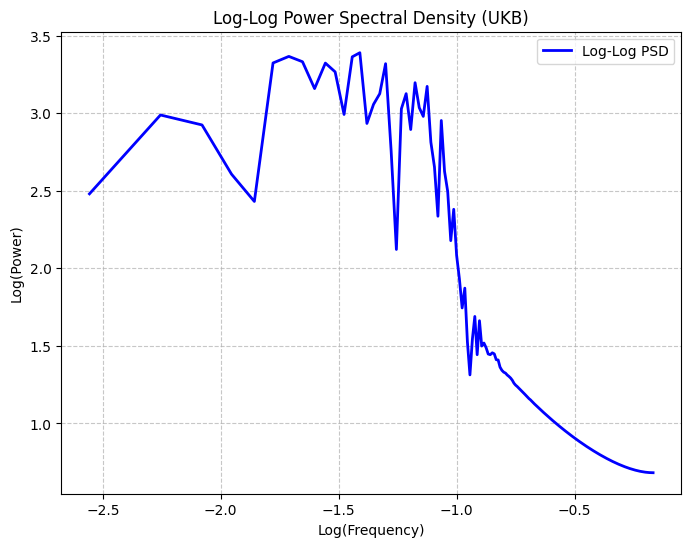

In [119]:
# Call the function to visualize log-log PSD
visualize_log_psd(xdata, ydata, f1, f2, title="Log-Log Power Spectral Density (UKB)")